In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import xarray as xr
import numpy as np
import pandas as pd

In [4]:
xr.set_options(keep_attrs=True)

In [5]:
import ecephys_analyses as ea 
from ecephys import utils
from ecephys.signal.xarray_utils import filter_dataset_by_hypnogram

In [6]:
def ds2df(ds):
    s = ds.to_dataframe().stack()
    s.index.names = s.index.names[:-1] + ['region']
    return s.to_frame(name='power')

In [7]:
subject = "Valentino"
experiment = "sleep-homeostasis"
norm_condition = "light-period-circadian-match"
bsl_condition = "recovery-sleep-circadian-match"
rec_condition = "recovery-sleep"
states = ["N1", "N2"]
duration = '02:00:00'
light_period_start = '09:00:00'
light_period_end = '21:00:00'
f_range = (0.5, 4)

In [8]:
norm_hyp = ea.load_hypnogram(subject, experiment, norm_condition)
norm_hyp = norm_hyp.keep_states(states).keep_between(light_period_start, light_period_end)

norm_pow = ea.load_power(subject, experiment, norm_condition, "spg.nc").sel(frequency=slice(*f_range)).sum(dim="frequency")
norm_pow = filter_dataset_by_hypnogram(norm_pow, norm_hyp).swap_dims({'time': 'datetime'}).drop_vars(['time', 'timedelta'])

In [9]:
rec_hyp = ea.load_hypnogram(subject, experiment, rec_condition)
rec_hyp = rec_hyp.keep_states(states).keep_first(duration)

rec_pow = ea.load_power(subject, experiment, rec_condition, "spg.nc").sel(frequency=slice(*f_range)).sum(dim='frequency')
rec_pow = filter_dataset_by_hypnogram(rec_pow, rec_hyp).swap_dims({'time': 'datetime'}).drop_vars(['time', 'timedelta'])
rec_pow = rec_pow / norm_pow.mean(dim="datetime") * 100

In [10]:
bsl_hyp = ea.load_hypnogram(subject, experiment, bsl_condition)
bsl_hyp = bsl_hyp.keep_states(states).keep_between(rec_hyp.start_time.min().strftime("%H:%M:%S"), light_period_end).keep_first(duration)

bsl_pow = ea.load_power(subject, experiment, bsl_condition, "spg.nc").sel(frequency=slice(*f_range)).sum(dim='frequency')
bsl_pow = filter_dataset_by_hypnogram(bsl_pow, bsl_hyp).swap_dims({'time': 'datetime'}).drop_vars(['time', 'timedelta'])
bsl_pow = bsl_pow / norm_pow.mean(dim="datetime") * 100

In [11]:
nrem_pow = pd.concat([ds2df(bsl_pow).assign(condition="baseline"), ds2df(rec_pow).assign(condition="recovery")])

In [12]:
nrem_pow

power condition
datetime            region                           
2020-02-19 15:08:05 mpta_wm_ref    8.322469  baseline
                    sr_wm_ref     23.606334  baseline
2020-02-19 15:08:08 mpta_wm_ref   12.742594  baseline
                    sr_wm_ref     20.952554  baseline
2020-02-19 15:08:11 mpta_wm_ref    8.731218  baseline
...                                     ...       ...
2020-02-20 17:49:31 sr_wm_ref    474.259289  recovery
2020-02-20 17:49:34 mpta_wm_ref  138.753466  recovery
                    sr_wm_ref     84.241144  recovery
2020-02-20 17:49:37 mpta_wm_ref  164.824322  recovery
                    sr_wm_ref    135.922204  recovery

[9578 rows x 2 columns]

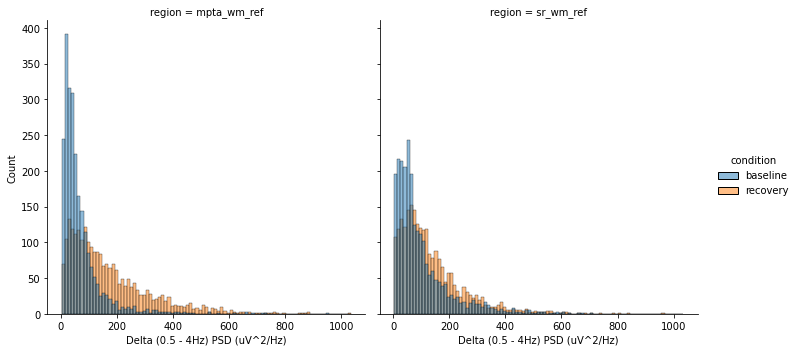

In [13]:
g = sns.displot(data=nrem_pow, x='power', hue='condition', col='region', kind='hist')
g.set(xlabel='Delta (0.5 - 4Hz) PSD (uV^2/Hz)')
g.tight_layout()

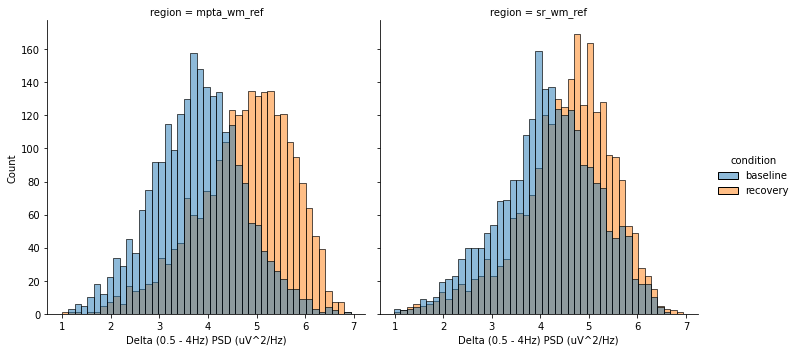

In [14]:
nrem_pow_log = nrem_pow.copy()
nrem_pow_log['power'] = np.log(nrem_pow.power)

g = sns.displot(data=nrem_pow_log, x='power', hue='condition', col='region', kind='hist')
g.set(xlabel='Delta (0.5 - 4Hz) PSD (uV^2/Hz)')
g.tight_layout()

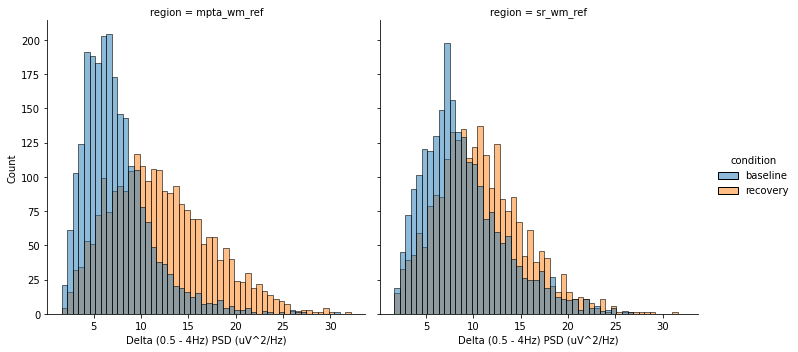

In [15]:
nrem_pow_sqrt = nrem_pow.copy()
nrem_pow_sqrt['power'] = np.sqrt(nrem_pow.power)

g = sns.displot(data=nrem_pow_sqrt, x='power', hue='condition', col='region', kind='hist')
g.set(xlabel='Delta (0.5 - 4Hz) PSD (uV^2/Hz)')
g.tight_layout()

In [16]:
def difference_of_means(df):
    means = df.groupby(['condition', 'region']).mean()
    return means.xs('recovery') - means.xs('baseline')

In [17]:
observed = difference_of_means(nrem_pow)

n_permutations = 10000
permutations = list()
permuted = nrem_pow.copy()
for i in range(n_permutations):
    np.random.shuffle(permuted.condition.values)
    permutations.append(difference_of_means(permuted))
    
df = pd.concat(permutations)

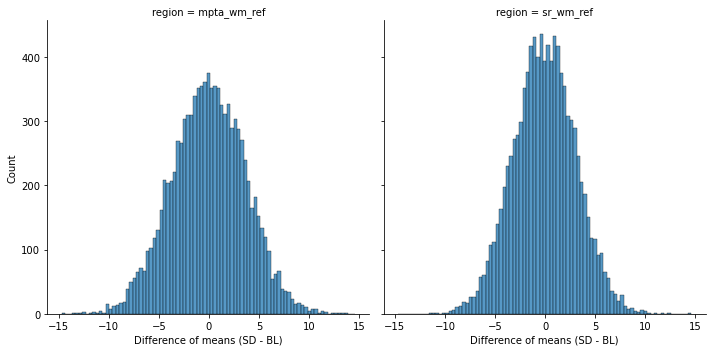

In [18]:
g = sns.displot(data=df, x='power', col='region', kind='hist')
g.set(xlabel='Difference of means (SD - BL)')
g.tight_layout()

In [19]:
cx = df.xs('mpta_wm_ref').sort_values('power')
hc = df.xs('sr_wm_ref').sort_values('power')

In [20]:
pcx = np.sum(cx.power.values >= observed.xs('mpta_wm_ref').values)

In [21]:
phc = np.sum(hc.power.values >= observed.xs('sr_wm_ref').values)

In [22]:
print(f"Subject: {subject}")
print('Observed differences, Mean SD - Mean BSL:\n')
print(observed.to_markdown())
print('\n')
print('Shuffled differences >= observed:')
print(f"Cortex: {1 + pcx} / {n_permutations}")
print(f"Hippocampus: {1 + phc} / {n_permutations}")

Subject: Valentino
Observed differences, Mean SD - Mean BSL:

| region      |    power |
|:------------|---------:|
| mpta_wm_ref | 103.253  |
| sr_wm_ref   |  35.9414 |


Shuffled differences >= observed:
Cortex: 1 / 10000
Hippocampus: 1 / 10000
